# Volcano Explorer
This notebook reads in the "coregistered" csv file which contains the original petlab geochemistry results at eruption locations with the values of the carbon grids attached to each of these points.

We can explore some of the correlations in the data. 

Finally this notebook generates several datasets for machine learning. 

Six files called *mldata_<geochem>.csv* contain the the carbon grids as features for ML and the specific <geochem> as target variables. 
    
Two files called *mldata_neg<age/loc>.csv* contain the data plus pseudo-randomly generated set of points with the corresponding sampled grids to perform different ML on.

In [401]:
#Load in required packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy

import sys
import glob
import os

#For converting between geolocal and numerical ages
from pyrolite.util.time import Timescale

sys.path.insert(1, '../pygplates_rev28_python37_win64')
import pygplates
import ptt

import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#For plotting histograms
from itertools import combinations

In [402]:
df=pd.read_csv("petlab_withgrids.csv")
df

#Load in the dataset representing "background" noise (PICK 1)

#Based on randomised ages
#dfneg=pd.read_csv("petlab_withgrids_neg_age.csv")

#Based on randomised locations
dfneg=pd.read_csv("petlab_withgrids_neg_loc.csv")

In [403]:
#Check column names
#print(df.columns.tolist())

#Check column types
#print(df.dtypes.tolist())

In [404]:
#Many of the grids are sampled with 0.0 when in fact there is no data there. 
#Replace these 0.0 values with nans
df.replace(to_replace=0.0, value=np.nan, inplace=True)
dfneg.replace(to_replace=0.0, value=np.nan, inplace=True)

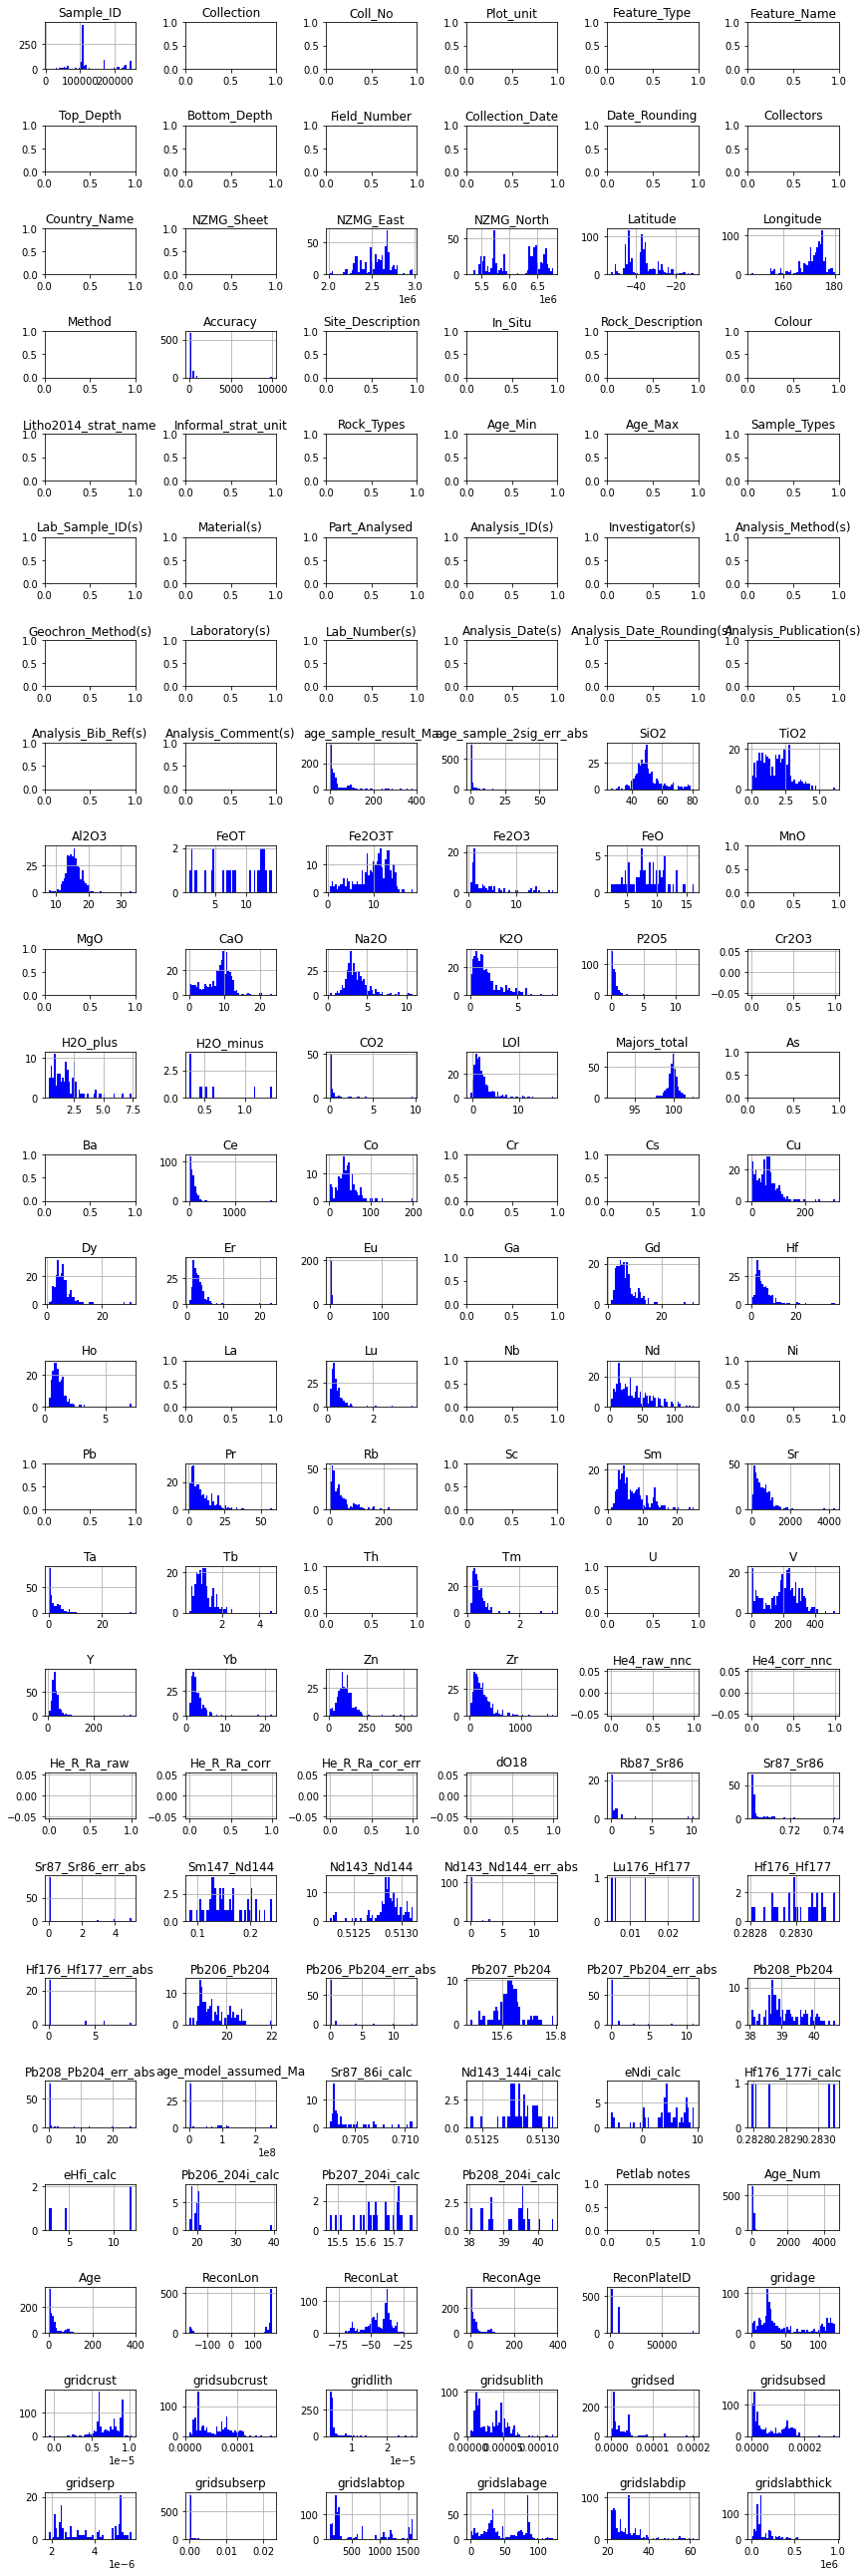

In [268]:
#Plot histograms of all the 'slab juices'/geochemisty
#These plots give an idea for the spread of values for each of the volcanic products and input grids.
#You may be able to see obvious distributions and make informed decisions for how to create target
# sets for ML (e.g. a bionomial distribution would suggest there are 2 "types" of volcanic events)

fig, axes = plt.subplots(len(df.columns)//6, 6, figsize=(12, 36))

i = 0
for triaxis in axes:
    for axis in triaxis:
        try:
            #dfneg.hist(column = dfneg.columns[i], bins = 50, ax=axis,color='r')
            df.hist(column = df.columns[i], bins = 50, ax=axis,color='b')
            #print(i, df.columns[i], df[df.columns[i]].count() )
        except:
            axis.set_title(df.columns[i])
            #print(df.columns[i], "not floats")

        i = i+1
    #print("done axis")
#print("done")
fig.tight_layout()
plt.show()

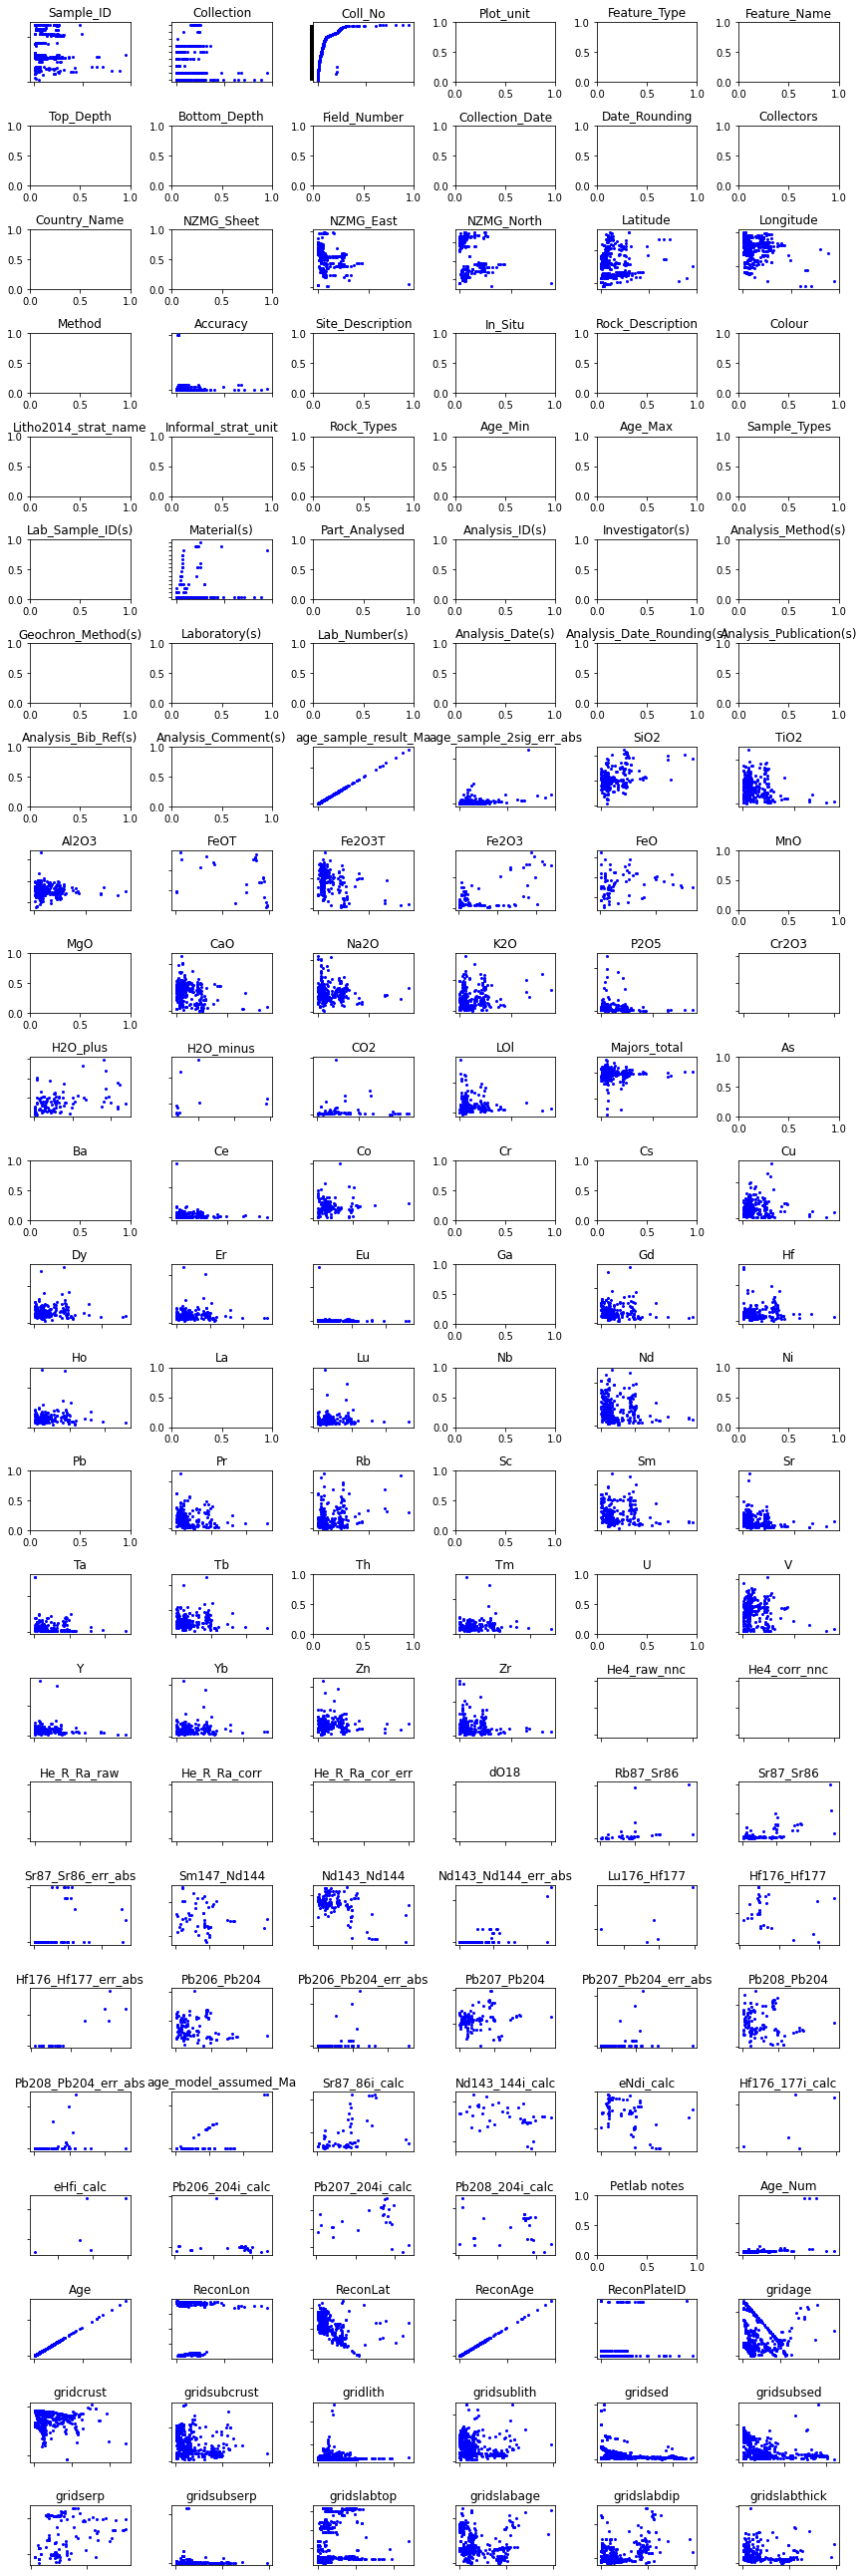

In [269]:
fig, axes = plt.subplots(len(df.columns)//6, 6, figsize=(12, 36))
#fig.tight_layout()
#fig, axes = plt.subplots(9//3, 3, figsize=(6, 6))
i = 0
for triaxis in axes:
    for axis in triaxis:
        try:
            axis.plot(df.ReconAge,df.iloc[:,i], 'b.')
            axis.yaxis.set_ticklabels([])
            axis.xaxis.set_ticklabels([])
            #axis.yticks([])
            #axis.xticks([])
            axis.set_title(df.columns[i])
        except:
            axis.set_title(df.columns[i])

        i = i+1
    #print("done axis")
#print("done")
fig.tight_layout()
plt.show()

<AxesSubplot:>

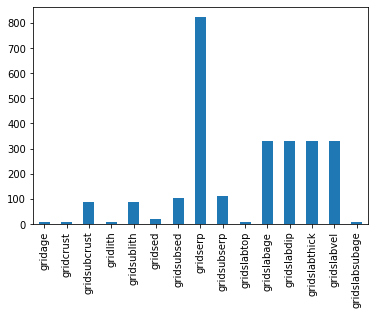

In [271]:
#How many NaNs per feature?
#More NaNs means it will be harder (re-useless) to use in the ML

vc_nulls = df.iloc[:,-15:].apply(lambda x: x.isnull().value_counts()).T[True]
#vc_nulls.hist() # if you want a histogram of these counts
## or if you wanted to plot the null count of each column as a bar
vc_nulls.plot(kind = 'bar')

In [471]:
#Set the list of parameter variable names we will use

#Drop gridserp because of too many nans.
#Pick one of the following geochem to include as targets... 'Hf','Nd','Nd143_Nd144','Hf176_Hf177','Pb207_Pb204','CO2'
sigvars=['CO2',
         'gridage', 'gridcrust', 'gridsubcrust', 'gridlith', 'gridsublith', 'gridsed', 'gridsubsed', 'gridsubserp',
        'gridslabtop','gridslabage','gridslabdip','gridslabthick','gridslabvel','gridslabsubage']

#Can include categorical variables too. But this adds unessecary complications
#catvars=['Plot_unit','Rock_Types','Age_Min','Age_Max']

In [472]:
#Make new datasets based on the selected parameters

#dfsub=df[sigvars+catvars].copy()
dfsub=df[sigvars].copy()

#Make the binary target one too
#dfnegsub=dfneg[sigvars+catvars].copy()
dfnegsub=dfneg[sigvars].copy()

In [473]:
#Set a random column as a random number to use as a benchmark in feature importantance
#Probably best if the number of random options mathches the number of target categories.
dfsub['random'] = np.random.choice([1,2,3,4,5], size=len(dfsub))

#dfsub['random'] = np.random.choice([-1,1], size=len(dfsub))
#dfnegsub['random'] = np.random.choice([-1,1], size=len(dfnegsub))

In [474]:
dfsub

,CO2,gridage,gridcrust,gridsubcrust,gridlith,gridsublith,gridsed,gridsubsed,gridsubserp,gridslabtop,gridslabage,gridslabdip,gridslabthick,gridslabvel,gridslabsubage,random
0,NaN,27.215429,0.000006,NaN,0.000004,NaN,0.000046,NaN,NaN,550.0,NaN,NaN,NaN,NaN,26.414402,3
1,NaN,105.411903,0.000009,0.000069,0.000004,0.000041,0.000006,0.000039,0.000718,210.0,32.78672,22.01977,225093.375,0.000875,26.285441,2
2,NaN,27.176504,0.000006,0.000018,0.000004,0.000008,0.000046,0.000005,0.000003,460.0,NaN,NaN,NaN,NaN,25.345132,5
3,NaN,121.650185,0.000009,0.000026,0.000004,0.000018,0.000129,0.000072,0.000003,160.0,NaN,NaN,NaN,NaN,39.000000,3
4,NaN,121.650185,0.000009,0.000026,0.000004,0.000018,0.000129,0.000072,0.000003,160.0,NaN,NaN,NaN,NaN,39.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [475]:
#Create the the 'target classification vector'

#This is somewhat arbitrarilly picked as 5 bins. This could be better chosen.

targets=pd.qcut(dfsub.CO2,5,labels=False)
#targets=pd.qcut(dfsub.Hf,5,labels=False)
#targets=pd.qcut(dfsub.Hf176_Hf177,5,labels=False)
#targets=pd.qcut(dfsub.Nd,5,labels=False)
#targets=pd.qcut(dfsub.Nd143_Nd144,5,labels=False)
#targets=pd.qcut(dfsub.Pb207_Pb204,5,labels=False)

#Merge the two datasets and save it out for exploration Matlab's Classification learner
#Add a column specifying whether this is a genuine volcanic eruption event, or one of our randomised/background noise samples.
#dfsub['vol']=1
#dfnegsub['vol']=-1

In [476]:
#For geochemistry targets
mldata=dfsub
mldata['vol']=targets

#OR

#For eruption events targets.
#mldata = pd.concat([dfsub, dfnegsub], ignore_index=True, sort=False)


In [399]:
#Save out the ML dataset to be used later
#mldata.to_csv("mldata_CO2.csv",index=False)
#mldata.to_csv("mldata_Hf.csv",index=False)
#mldata.to_csv("mldata_Hf176_Hf177.csv",index=False)
#mldata.to_csv("mldata_Nd.csv",index=False)
#mldata.to_csv("mldata_Nd143_Nd144.csv",index=False)
#mldata.to_csv("mldata_Pb207_Pb204.csv",index=False)

#mldata.to_csv("mldata_negage.csv",index=False)
#mldata.to_csv("mldata_negloc.csv",index=False)

<Figure size 3600x3600 with 0 Axes>

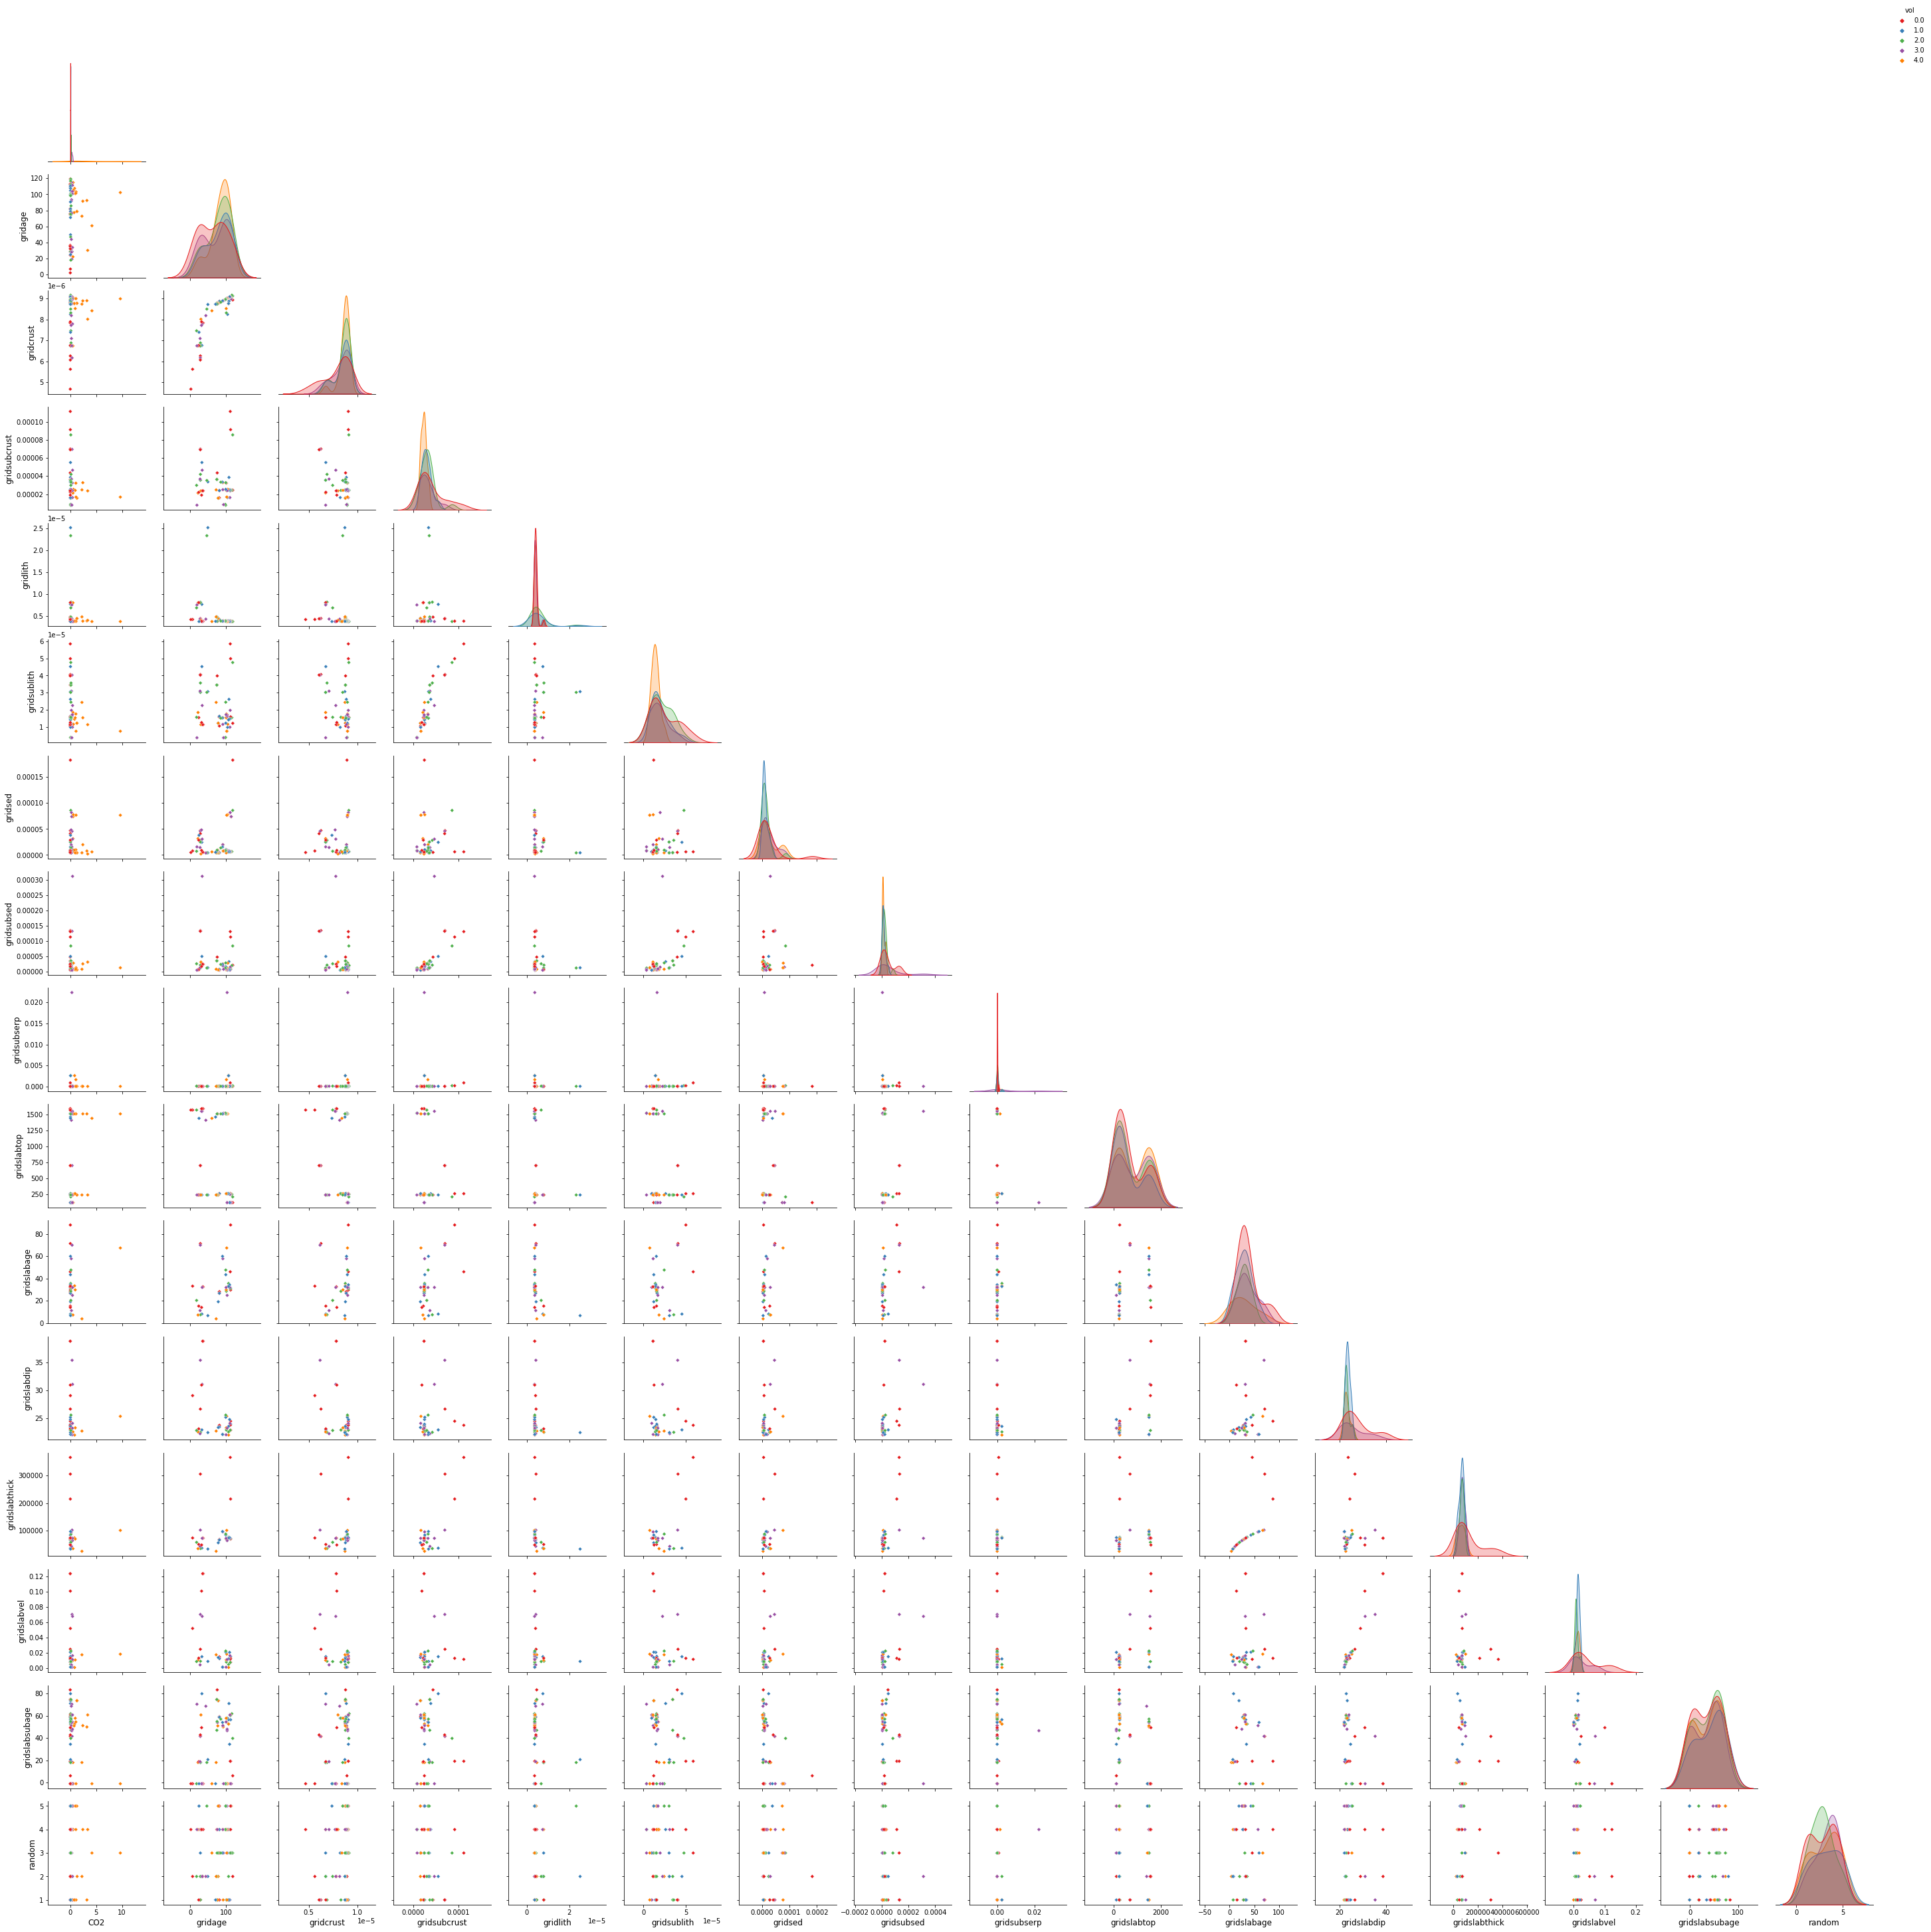

In [477]:
#Plot the variables
plt.figure(figsize=(36, 36), dpi = 100)
#fig, ss = plt.subplots(figsize = (24,24), dpi = 100)
cols_to_plot = mldata.columns.tolist()
sns.pairplot(mldata[cols_to_plot[:]],  hue ="vol",palette="Set1",corner=True)
#ss.legend(fontsize=20)
plt.savefig("results/variables_CO2.png")
#plt.show()